In [116]:
import os
import sys
import numpy as np
import argparse
import time
        
import SimpleITK as sitk
from scipy.io import loadmat
from scipy.optimize import least_squares, curve_fit, leastsq, root
from scipy.special import huber
from numpy.fft import fftn, ifftn
#from tqdm import trange, tqdm
from functools import partial
from multiprocessing import Pool, Lock, cpu_count, current_process
from multiprocessing.shared_memory import SharedMemory #V3.8+ only

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

app_name = 'pDate: proton density and T1/T2 Estimater'
version = '0.9.0'
release_date = '2022-11-25'

def print_header():
	print('\n\n')
	print(app_name, '- version: v', version, release_date, '\n')
	print('Computational Radiology Lab (CRL)\nBoston Children\'s Hospital, and Harvard Medical School\nhttp://crl.med.harvard.edu\nAuthor: Yao Sui')
	print('\n')


print_header()

def np_to_img(x, ref):
	img = sitk.GetImageFromArray(x)
	img.SetOrigin(ref.GetOrigin())
	img.SetSpacing(ref.GetSpacing())
	img.SetDirection(ref.GetDirection())
	return img
    
def aic(k, y_est, y_ref):
	return 2 * k + len(y_ref) * np.log(np.sum((y_est-y_ref)**2)/len(y_ref))

def aicc(k, y_est, y_ref):
	#return aic(k, y_est, y_ref) + 2 * k * (k+1) / (len(y_ref) - k - 1)
	n = len(y_ref)
	return np.log(np.sum((y_est-y_ref)**2)/n) + (n + k) / (n - k - 2)

def t1_model(ti, pd, t1, fa):
	return pd * (1 - (1 - np.cos(fa)) * np.exp(-ti / t1))

def cost_t1(x, ti, fa, y):
	t1 = np.clip(x[1], np.finfo(np.float32).eps, None)
	return x[0] * (1 - (1 - np.cos(fa)) * np.exp(-ti / t1)) - y

def t2_model(te, pd, t2):
	return pd * np.exp(-te/t2)

def cost_t2(x, te, y):
	t2 = np.clip(x[1], np.finfo(np.float32).eps, None)
	return x[0] * np.exp(-te/t2) - y

def cost_t1_t2(x, ti, fa, te, y1, y2):
	t1 = np.clip(x[1], np.finfo(np.float32).eps, None)
	cost_t1 = x[0] * (1 - (1 - np.cos(fa)) * np.exp(-ti / t1)) - y1
	t2 = np.clip(x[2], np.finfo(np.float32).eps, None)
	cost_t2 = x[0] * np.exp(-te/t2) - y2
	return np.concatenate([cost_t1, cost_t2], axis=-1)

def load_imgs(ii):
	shm_x = SharedMemory(name='x')
	x = np.ndarray([d,n,m,n_imgs], dtype=np.float32, buffer=shm_x.buf)

	img = sitk.ReadImage(flist[ii], sitk.sitkFloat32)
	print('loaded %d - %s ...' % (ii, flist[ii]))
	x[...,ii] = sitk.GetArrayFromImage(img)

	shm_x.close()
	print('Loaded image:', ii, flist[ii])

def init(l):
	global lock
	lock = l
    
def init_t1(y):
    pd0 = max(500, y[-1])
    if pd0 == 0:
        t10 = 0
    else:
        ti = TI[:-1]
        #t10 = TI[:-1] / -np.log(1/2 - 1/2*y[:-1]/pd0)
        
        tmp = 1/2 - 1/2*y[:-1]/pd0
        L = tmp > 0
        if np.all(L):
            t10 = np.mean(ti[L] / -np.log(tmp[L]))
            if t10 < 0:
                t10 = 500
        elif np.any(L):
            t10 = np.mean(ti[L] / -np.log(tmp[L]))
        else:
            t10 = 0
        

    t10 = max(0, min(t10, 5000))
    return [pd0, t10]
    
def init_t2(y):
    pd0 = max(0, y[0])
    if pd0 == 0:
        t20 = 0, 0
    else:
        t20 = TE[1:]/-np.log(y[1:]/pd0)
        if np.any(t20 > -np.inf):
            t20 = np.median(t20[t20>-np.inf])
        else:
            t20 = 0
    
    t20 = min(max(t20, 0), 4000)
    return [pd0, t20]

def compute_model(vidx, n_cores):
	# declare shared memory for numpy arrays
	shm_pd = SharedMemory(name='pd')
	pd = np.ndarray([d,n,m], dtype=np.float32, buffer=shm_pd.buf)
	shm_tm = SharedMemory(name='tm')
	tm = np.ndarray([d,n,m], dtype=np.float32, buffer=shm_tm.buf)
	shm_x = SharedMemory(name='x')
	x = np.ndarray([d,n,m,n_imgs], dtype=np.float32, buffer=shm_x.buf)

	#print(current_process().name, 'shared memory all declared', np.sum(pd), np.sum(x))

	#t0 = time.time()
	n_voxels = d * n * m
	job_size = len(range(vidx, n_voxels, n_cores))
	pd_local = np.empty(job_size)
	tm_local = np.empty(job_size)

	if vidx == 0:
		the_range = tqdm(range(vidx, n_voxels, n_cores))
	else:
		the_range = range(vidx, n_voxels, n_cores)

	kk = 0
	for vv in the_range:
		zz = int(np.floor(float(vv) / (d * n)))
		yy = int(vv % (d * n) % n)
		xx = int(np.floor(float(vv % (d * n)) / n))

		yii = np.squeeze(x[xx,yy,zz,:])
		if t1_mapping:
			r0 = init_t1(yii)
			res = least_squares(cost_t1, r0,
				args=(TI, fa, yii), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
		else:
			r0 = init_t2(yii)
			res = least_squares(cost_t2, r0,
				args=(TE, yii), loss='linear',
				bounds=([0, 0], [np.inf, 4000]))

		r = res.x

		pd_local[kk] = r[0]
		tm_local[kk] = r[1]

		kk += 1

	#lock.acquire()
	kk = 0
	for vv in range(vidx, n_voxels, n_cores):
		zz = int(np.floor(float(vv) / (d * n)))
		yy = int(vv % (d * n) % n)
		xx = int(np.floor(float(vv % (d * n)) / n))

		pd[xx,yy,zz] = pd_local[kk]
		tm[xx,yy,zz] = tm_local[kk]

		kk += 1
	#lock.release()
	#t = (time.time() - t0) * 1000. / job_size
	#print(current_process().name, 'generated', np.sum(np.isnan(pd)), t, 'ms per fit')


	# clean up for the shared memory
	shm_pd.close()
	shm_tm.close()
	shm_x.close()





pDate: proton density and T1/T2 Estimater - version: v 0.9.0 2022-11-25 

Computational Radiology Lab (CRL)
Boston Children's Hospital, and Harvard Medical School
http://crl.med.harvard.edu
Author: Yao Sui




In [117]:
data_path = 'data/'
out_path = 'recons/'

if not os.path.isdir(out_path):
	os.mkdir(out_path)

flist = sorted([os.path.join(data_path, f)
		for f in os.listdir(data_path) if not os.path.isdir(f)])
n_imgs = len(flist)
print('found %d images:\n' % n_imgs)
print('\n'.join(flist))

img0 = sitk.ReadImage(flist[0], sitk.sitkFloat32)

m, n, d = img0.GetSize()
pd = np.ndarray([d,n,m], dtype=np.float32)

TI=np.asarray([130,390,650,910,1170,1430,1690,1950,2380,2600])
fa=158
fa = np.array([float(fa) / 180. * np.pi ]) # because numpy.cosine wants radians and not degrees
print(fa,np.cos(fa))

found 10 images:

data/PSIR_Onur_0_7X0_7X2_TI0130_PSIR_Onur_0.7X0.7X2_TI0130_20230505105839_29_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI0390_PSIR_Onur_0.7X0.7X2_TI0390_20230505105839_31_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI0650_PSIR_Onur_0.7X0.7X2_TI0650_20230505105839_32_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI0910_PSIR_Onur_0.7X0.7X2_TI0910_20230505105839_33_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI1170_PSIR_Onur_0.7X0.7X2_TI1170_20230505105839_34_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI1430_PSIR_Onur_0.7X0.7X2_TI1430_20230505105839_37_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI1690_PSIR_Onur_0.7X0.7X2_TI1690_20230505105839_38_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI1950_PSIR_Onur_0.7X0.7X2_TI1950_20230505105839_39_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI2380_PSIR_Onur_0.7X0.7X2_TI2380_20230505105839_40_real.nii.gz
data/PSIR_Onur_0_7X0_7X2_TI2600_PSIR_Onur_0.7X0.7X2_TI2600_20230505105839_41_real.nii.gz
[2.75762022] [-0.92718385]


(240, 320, 60)
[-2002. -1930. -1894. ...   876.   892.   950.]
-1272.0


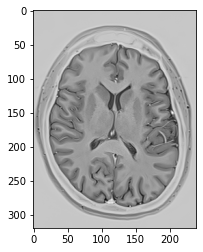

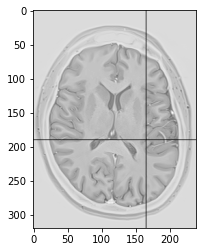

In [118]:
print((img0.GetSize()))
arr = sitk.GetArrayFromImage(img0)
plt.figure
plt.imshow(np.flip(np.flip(arr[30,:,:]),axis=1),cmap='gray')
print(np.unique(arr))
barr=np.copy(arr); barr[30,0:320,165]=-3000
barr[30,129,0:239]=-3000
plt.figure(2)
plt.imshow(np.flip(np.flip(barr[30,:,:]),axis=1),cmap='gray')
print(arr[30,129,165])
# Sure it matches with itk snap reads.
# On itksnap , enter 130,166, 31 as voxel co-ordinate. python = 30,129,165
x=30
y=129
z=165

In [119]:
point=[]
for i in range(len(TI)):
    img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
    arr = sitk.GetArrayFromImage(img0)
    point.append(arr[x,y,z])

point=np.asarray(point)
print(point)
# Check if the values are same for all TI images

[-1272.  -802.  -538.  -260.    20.   214.   376.   482.   776.   766.]


In [120]:
# Let us now check the estimator
init_point=init_t1(point)
print(point[-1])
print(init_point)

766.0
[766.0, 0]


In [147]:
y=np.copy(point)
pd0 = max(500, y[-1])
if pd0 == 0:
    t10 = 0
else:
    ti = TI[:-1]
    #t10 = TI[:-1] / -np.log(1/2 - 1/2*y[:-1]/pd0)
    
    tmp = 1/2 - 1/2*y[:-1]/pd0
    print(y[:-1])
    L = tmp > 0
    if np.all(L):
        t10 = np.mean(ti[L] / -np.log(tmp[L]))
        if t10 < 0:
            t10 = 500
    elif np.any(L):
        #L2=L[L==True]
        t10 = np.mean(ti[L] / -np.log(tmp[L]))
        if t10 < 0:
            t10 = 500

    else:
        t10 = 0
t10 = max(0, min(t10, 5000))
print(t10,pd0)

[-334. -442. -398. -188.  -72.    2.   90.  178.  304.]
2771.2021624113454 500


In [122]:
np.mean(ti[L])

1040.0

In [123]:
ti[:-1]

array([ 130,  390,  650,  910, 1170, 1430, 1690, 1950])

In [124]:
ti

array([ 130,  390,  650,  910, 1170, 1430, 1690, 1950, 2380])

In [125]:
a=L[L==True]

In [126]:
print(a)


[ True  True  True  True  True  True  True  True]


data/PSIR_Onur_0_7X0_7X2_TI0130_PSIR_Onur_0.7X0.7X2_TI0130_20230505105839_29_real.nii.gz
(240, 320, 60)
[-2002. -1930. -1894. ...   876.   892.   950.]
140.0


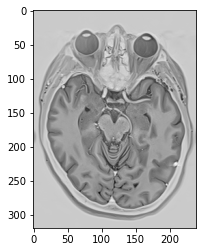

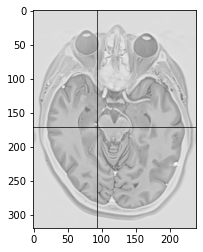

In [127]:
print(flist[0])
img0 = sitk.ReadImage(flist[0], sitk.sitkFloat32)
print((img0.GetSize()))
arr = sitk.GetArrayFromImage(img0)
plt.figure
plt.imshow(np.flip(np.flip(arr[20,:,:]),axis=1),cmap='gray')
print(np.unique(arr))
barr=np.copy(arr); barr[20,147,0:239]=-3000
barr[20,0:319,94]=-3000
plt.figure(2)
plt.imshow(np.flip(np.flip(barr[20,:,:]),axis=1),cmap='gray')
print(arr[20,147,94])
# Sure it matches with itk snap reads.

x=20
y=147
z=94

In [128]:
point=[]
for i in range(len(TI)):
    img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
    arr = sitk.GetArrayFromImage(img0)
    point.append(arr[x,y,z])

ypoint=np.copy(np.asarray(point))
print(point)
# Check if the values are same for all TI images

[140.0, 150.0, 120.0, 82.0, 0.0, -84.0, 4.0, 74.0, -118.0, -106.0]


In [129]:
y=y-1
point=[]
for i in range(len(TI)):
    img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
    arr = sitk.GetArrayFromImage(img0)
    point.append(arr[x,y,z])

yppoint=np.copy(np.asarray(point))
print(yppoint)
# Check if the values are same for all TI images

[-724. -334. -234. -128. -184. -102.  -42.   74.  -70.  -90.]


In [130]:
y=y+2
point=[]
for i in range(len(TI)):
    img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
    arr = sitk.GetArrayFromImage(img0)
    point.append(arr[x,y,z])

ypppoint=np.copy(np.asarray(point))
print(ypppoint)

[-226. -532. -502. -430. -230. -104.   12.  136.  272.  342.]


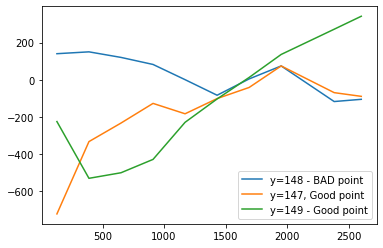

In [131]:
plt.plot(np.asarray(TI),ypoint,label='y=148 - BAD point')
plt.plot(np.asarray(TI),yppoint, label='y=147, Good point')
plt.plot(np.asarray(TI),ypppoint, label='y=149 - Good point')
plt.legend()
plt.show()

In [137]:
x=27
y=195
z=55
ypoint=[]
for y in range(193,196):
    point=[]
    for i in range(len(TI)):
        img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
        arr = sitk.GetArrayFromImage(img0)
        point.append(arr[x,y,z])
    print(point)
    ypoint.append(point)
ypoint=(np.asarray(ypoint))
print(ypoint)
# Check if the values are same for all TI images

[-888.0, -550.0, -358.0, -186.0, -82.0, -16.0, 54.0, 58.0, 76.0, -42.0]
[-440.0, -50.0, 226.0, 146.0, 126.0, 80.0, 60.0, 52.0, 4.0, 70.0]
[-192.0, -92.0, -176.0, -172.0, -190.0, -176.0, -6.0, 62.0, 240.0, 368.0]
[[-888. -550. -358. -186.  -82.  -16.   54.   58.   76.  -42.]
 [-440.  -50.  226.  146.  126.   80.   60.   52.    4.   70.]
 [-192.  -92. -176. -172. -190. -176.   -6.   62.  240.  368.]]


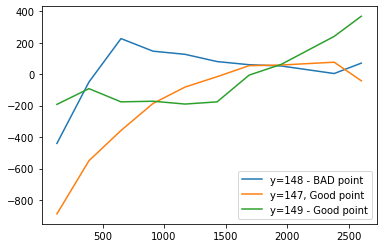

In [139]:
plt.plot(np.asarray(TI),ypoint[1],label='y=148 - BAD point')
plt.plot(np.asarray(TI),ypoint[0], label='y=147, Good point')
plt.plot(np.asarray(TI),ypoint[2], label='y=149 - Good point')
plt.legend()
plt.show()

[-982.0, -284.0, -114.0, -46.0, -158.0, -74.0, 26.0, 18.0, -14.0, 8.0]
[270.0, 148.0, 36.0, -10.0, -50.0, -38.0, -70.0, -34.0, -42.0, -66.0]
[-248.0, -622.0, -522.0, -314.0, -86.0, 40.0, 102.0, 298.0, 496.0, 548.0]
[[-982. -284. -114.  -46. -158.  -74.   26.   18.  -14.    8.]
 [ 270.  148.   36.  -10.  -50.  -38.  -70.  -34.  -42.  -66.]
 [-248. -622. -522. -314.  -86.   40.  102.  298.  496.  548.]]


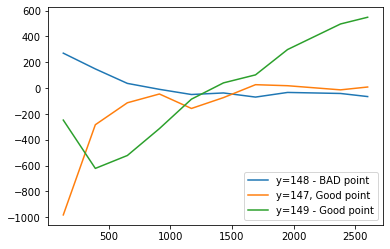

In [234]:
x=25
y=193
z=56
ypoint=[]
for y in range(y-1,y+2):
    point=[]
    for i in range(len(TI)):
        img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
        arr = sitk.GetArrayFromImage(img0)
        point.append(arr[x,y,z])
    print(point)
    ypoint.append(point)
ypoint=(np.asarray(ypoint))
print(ypoint)
# Check if the values are same for all TI images
plt.plot(np.asarray(TI),ypoint[1],label='y=148 - BAD point')
plt.plot(np.asarray(TI),ypoint[0], label='y=147, Good point')
plt.plot(np.asarray(TI),ypoint[2], label='y=149 - Good point')
plt.legend()
plt.show()

4999.999999999999


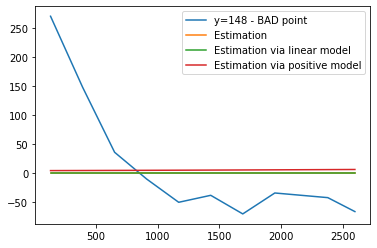

In [246]:
aa=init_t1(ypoint[1])
fa = 158 / 180. * np.pi 
def linear_cost_t1(x, ti, fa, y):
    t1 = np.clip(x[1], np.finfo(np.float32).eps, None)
    return x[0] * (1 - (1 - np.cos(fa)) * (1+ (-ti / t1))) - y

def pos_exp_cost_t1(x, ti, fa, y):
    t1 = np.clip(x[1], np.finfo(np.float32).eps, None)
    return x[0] * (1 - (1 - np.cos(fa)) * (np.exp(ti / t1))) - y

res = least_squares(cost_t1, aa,
				args=(TI, fa, ypoint[1]), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
r=res.x
print(r[1])

res = least_squares(linear_cost_t1, aa,
				args=(TI, fa, ypoint[1]), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
rlinear=res.x

res = least_squares(pos_exp_cost_t1, aa,
				args=(TI, fa, ypoint[1]), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
rposexp=res.x

fitt=np.empty(10)
fittl=np.empty(10)
fittpexp=np.empty(10)
for i in range(len(TI)):
    fitt[i]= r[0] * (1 - (1 - np.cos(fa)) * np.exp(-TI[i] / r[1])) 
    fittl[i]= rlinear[0] * (1 - (1 - np.cos(fa)) * (1+(-TI[i] / rlinear[1]))) 
    fittpexp[i]= rposexp[0] * (1 - (1 - np.cos(fa)) * (-np.exp(TI[i] / rposexp[1]))) 
    
plt.plot(np.asarray(TI),ypoint[1],label='y=148 - BAD point')
plt.plot(np.asarray(TI),fitt,label='Estimation')
plt.plot(np.asarray(TI),fittl,label='Estimation via linear model')
plt.plot(np.asarray(TI),fittpexp,label='Estimation via positive model')
plt.legend()
plt.show()


[-958.0, -396.0, -272.0, -120.0, -114.0, -18.0, -2.0, 40.0, 96.0, 122.0]
[32.0, 12.0, 36.0, 44.0, 66.0, 62.0, 34.0, 38.0, 0.0, -34.0]
[-334.0, -442.0, -398.0, -188.0, -72.0, 2.0, 90.0, 178.0, 304.0, 334.0]
[[-958. -396. -272. -120. -114.  -18.   -2.   40.   96.  122.]
 [  32.   12.   36.   44.   66.   62.   34.   38.    0.  -34.]
 [-334. -442. -398. -188.  -72.    2.   90.  178.  304.  334.]]


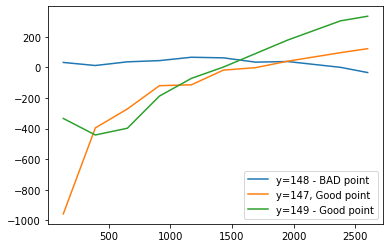

In [209]:
x=24
y=194
z=58
ypoint=[]
for y in range(y-1,y+2):
    point=[]
    for i in range(len(TI)):
        img0 = sitk.ReadImage(flist[i], sitk.sitkFloat32)
        arr = sitk.GetArrayFromImage(img0)
        point.append(arr[x,y,z])
    print(point)
    ypoint.append(point)
ypoint=(np.asarray(ypoint))        
print(ypoint)
# Check if the values are same for all TI images
plt.plot(np.asarray(TI),ypoint[1],label='y=148 - BAD point')
plt.plot(np.asarray(TI),ypoint[0], label='y=147, Good point')
plt.plot(np.asarray(TI),ypoint[2], label='y=149 - Good point')
plt.legend()
plt.show()

In [239]:
aa=init_t1(ypoint[1])
aa

[500, 1880.4836553012226]

4999.999999999999


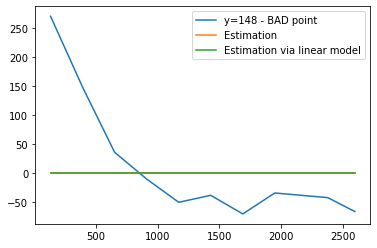

In [242]:
fa = 158 / 180. * np.pi 
def linear_cost_t1(x, ti, fa, y):
    t1 = np.clip(x[1], np.finfo(np.float32).eps, None)
    return x[0] * (1 - (1 - np.cos(fa)) * (1+ (-ti / t1))) - y

res = least_squares(cost_t1, aa,
				args=(TI, fa, ypoint[1]), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
r=res.x
print(r[1])

res = least_squares(linear_cost_t1, aa,
				args=(TI, fa, ypoint[1]), loss='linear',
				bounds=([0, 0], [np.inf, 5000]))
rlinear=res.x
fittl=np.empty(10)
for i in range(len(TI)):
    fitt[i]= r[0] * (1 - (1 - np.cos(fa)) * np.exp(-TI[i] / r[1])) 
    fittl[i]= rlinear[0] * (1 - (1 - np.cos(fa)) * (1+(-TI[i] / rlinear[1]))) 
    
plt.plot(np.asarray(TI),ypoint[1],label='y=148 - BAD point')
plt.plot(np.asarray(TI),fitt,label='Estimation')
plt.plot(np.asarray(TI),fittl,label='Estimation via linear model')
plt.legend()
plt.show()

In [161]:
import ants
pd=ants.image_read('recons/pd.nrrd')
t1=ants.image_read('recons/tm.nrrd')
y=ants.image_read('data/PSIR_Onur_0_7X0_7X2_TI1170_PSIR_Onur_0.7X0.7X2_TI1170_20230505105839_34_real.nii.gz')

In [191]:
pdim = sitk.GetImageFromArray(pd.numpy())
tmim = sitk.GetImageFromArray(t1.numpy())
yim = sitk.GetImageFromArray(y.numpy())
slicepd = sitk.GetArrayFromImage(pdim)[..., 35]
slicetm = sitk.GetArrayFromImage(tmim)[..., 35]
slicey = sitk.GetArrayFromImage(yim)[..., 35]
#print(xd,yd,zd)


In [192]:
print(slicepd[100,100],slicey[100,100])
[a,b]=(np.shape(slicepd))

882.5557 334.0


In [204]:
k=0
fa=np.zeros([a,b])
ti=1.170
for i in range(a):
    for j in range(b):
        fa[i,j]=np.degrees(np.arccos(1- (1 - (slicey[i,j] / slicepd[i,j]))*np.exp(ti/slicetm[i,j])))


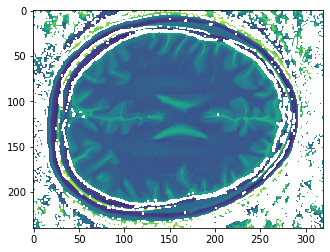

In [194]:
plt.imshow(fa)

-313.4037 2699.538


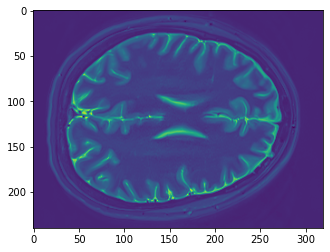

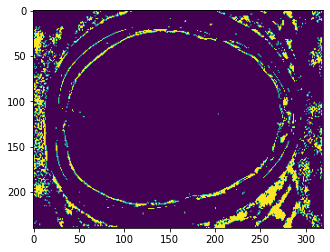

In [195]:
plt.figure
plt.imshow(slicepd-slicey)
print(np.min(slicepd-slicey),np.max(slicepd-slicey))
aa=np.zeros([a,b])
aa[(slicepd-slicey)<0]=1
plt.figure(2)
plt.imshow(aa)

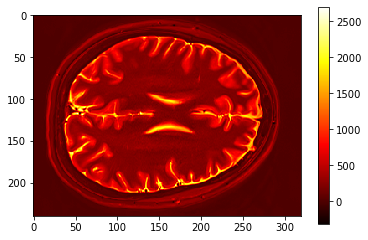

In [196]:
heatmap = plt.imshow(slicepd-slicey, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)

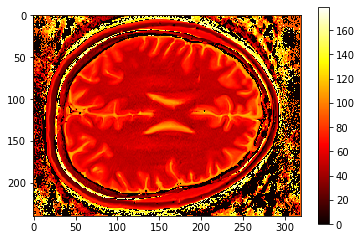

In [197]:
fa[np.isnan(fa)]=0
heatmap = plt.imshow(fa, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)

In [198]:
np.mean(fa)

57.34045829686358

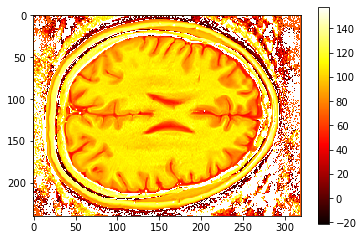

In [199]:
heatmap = plt.imshow(158-fa, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)

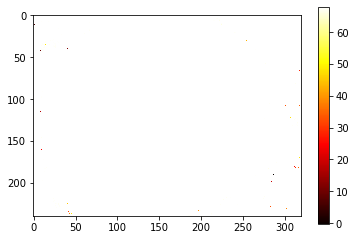

In [201]:
k=0
fa=np.zeros([a,b])
ti=1.170
for i in range(a):
    for j in range(b):
        fa[i,j]=np.degrees(np.arccos(1- (1 - (slicey[i,j] / 1.25*slicey[i,j]))*np.exp(ti/slicetm[i,j])))


heatmap = plt.imshow(158-fa, cmap='hot', interpolation='nearest')
plt.colorbar(heatmap)

In [202]:
print(np.mean(fa))

nan


(array([  32.,   87.,  141.,  177.,  290.,  446.,  655., 1255., 1297.,
        1048., 1012., 1004., 2095., 6575., 7997., 4244., 3073., 2994.,
        2909., 3047., 2706., 1815., 1166.,  841.,  686., 5085.,  610.,
         621.,  735.,  779.,  719.,  413.,  360.,  351.,  394.,  403.,
         366.,  456.,  459.,  464.,  486.,  481.,  437.,  443.,  400.,
         345.,  251.,  164.,   88.,   49.]),
 array([  0.        ,   3.58931492,   7.17862983,  10.76794475,
         14.35725967,  17.94657459,  21.5358895 ,  25.12520442,
         28.71451934,  32.30383426,  35.89314917,  39.48246409,
         43.07177901,  46.66109393,  50.25040884,  53.83972376,
         57.42903868,  61.0183536 ,  64.60766851,  68.19698343,
         71.78629835,  75.37561327,  78.96492818,  82.5542431 ,
         86.14355802,  89.73287294,  93.32218785,  96.91150277,
        100.50081769, 104.09013261, 107.67944752, 111.26876244,
        114.85807736, 118.44739228, 122.03670719, 125.62602211,
        129.21533703, 13

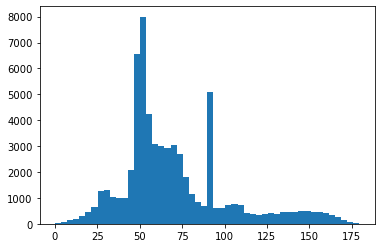

In [208]:
plt.hist(fa.flatten(), bins=50)